In [ ]:
! pip install pymilvus==2.2.5 torch gdown torchvision tqdm

In [1]:
import gdown
import zipfile

url = 'https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_'
output = './paintings.zip'
gdown.download(url, output)

with zipfile.ZipFile("./paintings.zip","r") as zip_ref:
    zip_ref.extractall("./paintings")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_
From (redirected): https://drive.google.com/uc?id=1OYDHLEy992qu5C4C8HV5uDIkOWRTAR1_&confirm=t&uuid=561a6c9c-0f4e-412a-9351-dee7d5ffc0c3
To: /Users/yujiantang/Documents/workspace/hello_world_project/paintings.zip
100%|██████████| 2.35G/2.35G [04:49<00:00, 8.12MB/s]


In [14]:
# Zilliz Cloud Setup Arguments
COLLECTION_NAME = 'image_search'  # Collection name
DIMENSION = 2048  # Embedding vector size in this example

# only need the following for Zilliz Cloud
# URI = 'https://replace-this-with-your-zilliz-cloud-endpoint'  # Endpoint URI obtained from Zilliz Cloud
# USER = 'replace-this-with-your-zilliz-cloud-database-user'  # Username specified when you created this database
# PASSWORD = 'replace-this-with-your-zilliz-cloud-database-password'  # Password set for that account
# above not needed for local instance

# Inference Arguments
BATCH_SIZE = 128
TOP_K = 3

In [3]:
from pymilvus import connections

In [4]:
connections.connect()

In [5]:
from pymilvus import utility
if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)

In [6]:
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='image_embedding', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
]
schema = CollectionSchema(fields=fields)
collection = Collection(name=COLLECTION_NAME, schema=schema)

In [10]:
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {"nlist": 128},
}
collection.create_index(field_name="image_embedding", index_params=index_params)
collection.load()

In [9]:
import glob

In [10]:
paths = glob.glob('./paintings/paintings/**/*.jpg', recursive=True)
len(paths)

4978

In [11]:
# run this before importing th resnet50 model if you run into an SSL certificate URLError
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [1]:
import torch
# Load the embedding model with the last layer removed
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

Using cache found in /Users/yujiantang/.cache/torch/hub/pytorch_vision_v0.10.0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [2]:
from torchvision import transforms

In [3]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
from PIL import Image
from tqdm import tqdm

In [16]:
def embed(data):
    with torch.no_grad():
        output = model(torch.stack(data[0])).squeeze()
        collection.insert([data[1], output.tolist()])

In [17]:
data_batch = [[], []]

for path in tqdm(paths):
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)
    if len(data_batch[0]) % BATCH_SIZE == 0:
        embed(data_batch)
        data_batch = [[], []]

if len(data_batch[0]) != 0:
    embed(data_batch)

collection.flush()

  3%|▎         | 127/4978 [00:14<09:18,  8.69it/s]

[[0.032517239451408386, 0.766340970993042, 0.004190642386674881, 0.1458115428686142, 0.17624250054359436, 0.05110597610473633, 0.2830638289451599, 0.0431763119995594, 0.23163427412509918, 0.06667336076498032, 0.06624758243560791, 0.23130351305007935, 0.7864765524864197, 0.25677719712257385, 0.06513054668903351, 0.5974013209342957, 0.10276521742343903, 0.3104272484779358, 0.18802642822265625, 1.3543965816497803, 0.7702873349189758, 0.2966899871826172, 0.7330029606819153, 0.49315276741981506, 0.6805569529533386, 0.29643043875694275, 1.1391291618347168, 0.16677983105182648, 0.14354491233825684, 0.07575162500143051, 1.01457941532135, 0.16288572549819946, 1.4448670148849487, 0.2570957541465759, 1.3404791355133057, 0.5649164915084839, 0.4394700825214386, 0.009320074692368507, 0.5708861947059631, 0.29049521684646606, 0.22637209296226501, 0.7926018238067627, 0.6704076528549194, 1.7668150663375854, 0.12826639413833618, 0.5675795674324036, 0.8224790096282959, 0.40494635701179504, 0.3566341400146

NameError: name 'collection' is not defined

In [29]:
import time
from matplotlib import pyplot as plt

In [83]:
search_paths = glob.glob('./paintings/test_paintings/Dali/**/*.jpg', recursive=True)
len(search_paths)

5

In [84]:
def embed(data):
    with torch.no_grad():
        ret = model(torch.stack(data))
        if len(ret) > 1:
            return ret.squeeze().tolist()
        else:
            return torch.flatten(ret, start_dim=1).tolist()
data_batch = [[], []]

for path in search_paths:
    im = Image.open(path).convert('RGB')
    data_batch[0].append(preprocess(im))
    data_batch[1].append(path)

embeds = embed(data_batch[0])
start = time.time()
res = collection.search(embeds, 
                        anns_field='image_embedding', 
                        param={"metric_type": "L2",
                               "params": {"nprobe": 10}}, 
                        limit=TOP_K, 
                        output_fields=['filepath'])
finish = time.time()
print(finish - start)

0.06294012069702148


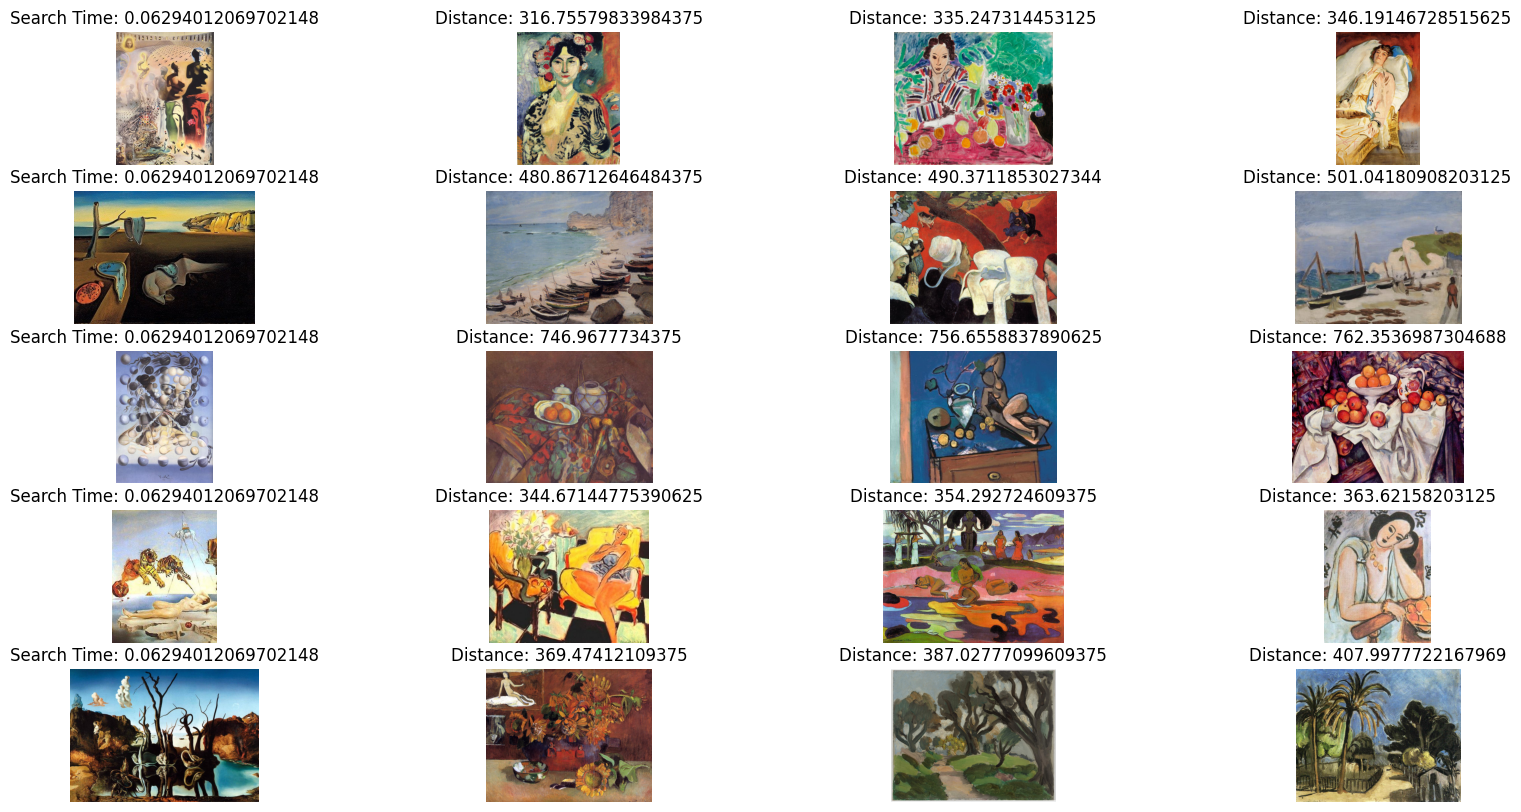

In [85]:
f, axarr = plt.subplots(len(data_batch[1]), TOP_K + 1, figsize=(20, 10), squeeze=False)

# print(type(res))

for hits_i, hits in enumerate(res):
    axarr[hits_i][0].imshow(Image.open(data_batch[1][hits_i]))
    axarr[hits_i][0].set_axis_off()
    axarr[hits_i][0].set_title('Search Time: ' + str(finish - start))
    for hit_i, hit in enumerate(hits):
        axarr[hits_i][hit_i + 1].imshow(Image.open(hit.entity.get('filepath')))
        axarr[hits_i][hit_i + 1].set_axis_off()
        axarr[hits_i][hit_i + 1].set_title('Distance: ' + str(hit.distance))

# Save the search result in a separate image file alongside your script.
plt.savefig('Dali_search_result.png')

In [86]:
for hits_i, hits in enumerate(res):
    for hit_it, hit in enumerate(hits):
        print(hit.entity)

id: 440864818485270739, distance: 316.75579833984375, entity: {'filepath': './paintings/paintings/training/training/Matisse/9223372032559820932.jpg'}
id: 440864818485270537, distance: 335.247314453125, entity: {'filepath': './paintings/paintings/training/training/Matisse/9223372032559820579.jpg'}
id: 440864818485272223, distance: 346.19146728515625, entity: {'filepath': './paintings/paintings/training/training/Sargent/265782.jpg'}
id: 440864818485269134, distance: 480.86712646484375, entity: {'filepath': './paintings/paintings/training/training/Monet/211781.jpg'}
id: 440864818485272970, distance: 490.3711853027344, entity: {'filepath': './paintings/paintings/training/training/Gauguin/190890.jpg'}
id: 440864818485270618, distance: 501.04180908203125, entity: {'filepath': './paintings/paintings/training/training/Matisse/9223372032559821365.jpg'}
id: 440864818485274397, distance: 746.9677734375, entity: {'filepath': './paintings/paintings/validation/validation/Cezanne/215889.jpg'}
id: 440